In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        tree = ET.parse(annotation_path) 
        root = tree.getroot() 
        # get bounding box coordinates
        num_objs = 0
        boxes = []
        for member in root.findall('object'):
            class_name = member[0].text # class name

            # bbox coordinates
            xmin = int(member[5][0].text)
            ymin = int(member[5][1].text)
            xmax = int(member[5][2].text)
            ymax = int(member[5][3].text)
            boxes.append([xmin, ymin, xmax, ymax])
            num_objs += 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["image_id"] = image_id
        #target["area"] = area

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
import cv2
import matplotlib.pyplot as plt
import random

def display_rand_images():
    dataset = CarDataset('../Data')
    for i in range(0, 9):
        index = random.randint(0, len(dataset) - 1)
        image = dataset[index + 1][0].copy()
        box = np.array(dataset[index + 1][1]["boxes"][0])
        imag = cv2.rectangle(np.asarray(image), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)
        im_pil = Image.fromarray(imag)
        plt.subplot(3, 3, i + 1)
        plt.imshow(im_pil)

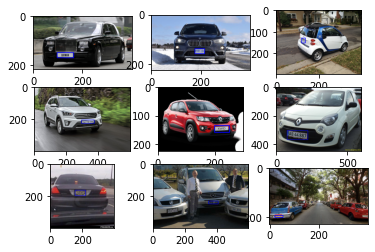

In [4]:
display_rand_images()

In [3]:
import torch
import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, img, target):
        
        image, b_boxes = np.asarray(img), np.array(target["boxes"])
        image_copy = np.copy(image)
        b_boxes_copy = np.copy(b_boxes)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        boxes = []
        for b_box_copy in b_boxes_copy:
            b_box_copy = (b_box_copy - 200)/200.0
            boxes.append(np.array(b_box_copy, dtype= np.float32))
        targets["boxes"] = torch.from_numpy(np.array(boxes))

        return Image.fromarray(image_copy), targets


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image, targets):
        image, b_boxes = np.asarray(image), np.array(targets["boxes"])

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(np.asarray(image), (new_w, new_h))
        boxes = []
        # scale the pts, too
        for b_box in b_boxes:
            b_box = np.reshape(np.array(b_box), (2,2)) * [new_w / w, new_h / h]
            b_box = np.reshape(np.array(b_box), (4,))
            boxes.append(np.array(b_box, dtype= np.float32))
        targets["boxes"] = torch.from_numpy(np.array(boxes))
        
        return Image.fromarray(img), targets



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image, targets):
        image, b_boxes = np.asarray(image), np.array(targets["boxes"])
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        #targets["boxes"] = torch.from_numpy(np.array(b_boxes))
        
        return Image.fromarray(image), targets

tensor([ 54.0000, 167.3554, 120.0000, 220.6612])


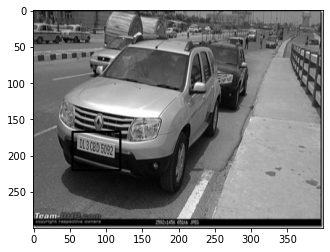

In [4]:
# test out some of these transforms

composed = transforms.Compose([ Rescale((300,400)), Normalize()
                                ])

# apply the transforms to a sample image
dataset = CarDataset('../Data')
test_num = 60
img, targets = dataset[test_num]

fig = plt.figure()
transformed_sample = composed(img, targets)
imag = np.asarray(transformed_sample[0])
for box in transformed_sample[1]["boxes"] :
    box = (box * 200) + 200
    print(box)
    imag = cv2.rectangle(imag, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)


plt.imshow(imag, cmap = 'gray')

In [29]:
dataset = CarDataset('../Data')
test_num = 140
img, targets = dataset[test_num]

targets["boxes"]

tensor([[347., 231., 407., 249.]])

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 1  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from models import Net
# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone = Net()
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 32

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=1,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [1]:
from models import Net

net = Net()
net.out_channels = 32
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout(p=0.4, inplace=False)
)


In [7]:
import transforms as T

def get_transform(train):
    transforms = [Rescale((300,400)), Normalize()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 1
    # use our dataset and defined transformations
    dataset = CarDataset('../Data', get_transform(train=True))
    dataset_test = CarDataset('../Data', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    indices.remove(0)
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    #model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [9]:
main()

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataset.py", line 363, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-1-77a0eac2528d>", line 56, in __getitem__
    img, target = self.transforms(img, target)
  File "/root/License_Plate_Detector/1_Prepare_data/Notebooks/transforms.py", line 27, in __call__
    image, target = t(image, target)
  File "/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/License_Plate_Detector/1_Prepare_data/Notebooks/transforms.py", line 38, in forward
    _, _, width = F.get_dimensions(image)
AttributeError: module 'torchvision.transforms.functional' has no attribute 'get_dimensions'


In [1]:
import torch
    
print(torch.__version__) 

1.10.1+cu102


In [10]:
!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-qjntuifh
  Running command git clone --filter=blob:none -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-qjntuifh
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
  Resolved https://github.com/gautamchitnis/cocoapi.git to commit 20291f19c46a8d11935862bc9e449a1b72ec25ed
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=274302 sha256=91ad00386222451f69ee7c4e1047a585604a8ffad02d69d91c958f6d8fc830b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-zh8fnvyo/wheels/9d/b5/c2/7c9f2a49530bde8bd32fcfcb0bb1b6b2fbd38418362de668c4
Successfully built pycocotools


/bin/sh: 1: pytorch: not found
